# FVCOM Dye Time Series Extraction Demo
**Author: Jun Sasaki  Coded on 2025-10-14  Updated on 2025-10-14**<br>

This notebook demonstrates the use of `xfvcom.dye_timeseries` for extracting and analyzing dye concentration time series from multi-year FVCOM ensemble runs.

## Features
- Load and aggregate dye data across multiple years and ensemble members
- Handle negative values (undershoots) with configurable policies
- Multiple time alignment strategies (intersection, same calendar, climatology)
- Linearity verification for ensemble consistency
- Visualization and export capabilities

## 1. Environment Check and Imports

In [1]:
import sys
from pathlib import Path

# Add xfvcom to path
xfvcom_root = Path.cwd().parents[1]
sys.path.insert(0, str(xfvcom_root))

import json
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import gridspec
import zarr

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    print("This cell is skipped.")

from xfvcom.dye_timeseries import (
    DyeCase,
    Selection,
    Paths,
    NegPolicy,
    AlignPolicy,
    collect_member_files,
    aggregate,
    negative_stats,
    verify_linearity,
)

# Import time series plotting utilities
from xfvcom.plot import (
    FvcomPlotConfig,
    plot_ensemble_timeseries,
    plot_ensemble_statistics,
)

print("✓ Imports successful")
print(f"Current directory: {Path.cwd()}")
print(f"xfvcom root: {xfvcom_root}")
print(f"Added to sys.path: {xfvcom_root in [Path(p) for p in sys.path]}")

✓ Imports successful
Current directory: /home/pj24001722/ku40000343/Github/xfvcom/examples/notebooks
xfvcom root: /home/pj24001722/ku40000343/Github/xfvcom
Added to sys.path: True


## 2. Configuration

Define the extraction parameters.

In [2]:
# Path configuration
# Notebook is in xfvcom/examples/notebooks/, so go up 3 levels to Github/
tb_fvcom_dir = Path.cwd().parents[2] / "TB-FVCOM"
output_dir = Path.cwd().parent / "output"
output_dir.mkdir(exist_ok=True)

print(f"TB-FVCOM directory: {tb_fvcom_dir}")
print(f"Output directory: {output_dir}")
print(f"TB-FVCOM exists: {tb_fvcom_dir.exists()}")

# Case configuration
basename = "tb_w18_r16"
years = [2021]  # Start with single year for demo
members = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]  # Subset of members

# Spatial selection (example nodes and sigma layers)
# Note: Adjust these to actual nodes of interest in your domain
nodes = [100]  # Example node indices
sigmas = [0]  # Surface and sub-surface layers

# Policies
neg_policy = "keep"  # or "clip_zero"
align_mode = "native_intersection"  # or "same_calendar" or "climatology"

print(f"\nConfiguration:")
print(f"  Basename: {basename}")
print(f"  Years: {years}")
print(f"  Members: {members}")
print(f"  Nodes: {nodes}")
print(f"  Sigma layers: {sigmas}")
print(f"  Negative policy: {neg_policy}")
print(f"  Alignment mode: {align_mode}")

TB-FVCOM directory: /home/pj24001722/ku40000343/Github/TB-FVCOM
Output directory: /home/pj24001722/ku40000343/Github/xfvcom/examples/output
TB-FVCOM exists: True

Configuration:
  Basename: tb_w18_r16
  Years: [2021]
  Members: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
  Nodes: [100]
  Sigma layers: [0]
  Negative policy: keep
  Alignment mode: native_intersection


## 3. Load and Aggregate Data

In [3]:
# Build configuration objects
paths = Paths(tb_fvcom_dir=tb_fvcom_dir)
case = DyeCase(basename=basename, years=years, members=members)
sel = Selection(nodes=nodes, sigmas=sigmas)
neg = NegPolicy(mode=neg_policy)
align_policy = AlignPolicy(mode=align_mode)

# Collect files
print("Collecting member files...")
member_map = collect_member_files(paths, case)
print(f"✓ Found files for {len(member_map)} (year, member) pairs\n")

# List all collected files
print("Member files:")
for (year, member), files in sorted(member_map.items()):
    print(f"  (year={year}, member={member}):")
    for f in files:
        print(f"    - {f.name}")

# Aggregate
print("\nAggregating time series...")
ds = aggregate(member_map, case, sel, neg, align_policy)

print(f"\n✓ Aggregation complete")
print(f"  Dataset dimensions: {dict(ds.sizes)}")
print(f"  Data variables: {list(ds.data_vars)}")
print(f"  Coordinates: {list(ds.coords)}")

# Display dataset info
ds

✓ Found files for 18 (year, member) pairs

Member files:
  (year=2021, member=1):
    - tb_w18_r16_2021_1_0001.nc
  (year=2021, member=2):
    - tb_w18_r16_2021_2_0001.nc
  (year=2021, member=3):
    - tb_w18_r16_2021_3_0001.nc
  (year=2021, member=4):
    - tb_w18_r16_2021_4_0001.nc
  (year=2021, member=5):
    - tb_w18_r16_2021_5_0001.nc
  (year=2021, member=6):
    - tb_w18_r16_2021_6_0001.nc
  (year=2021, member=7):
    - tb_w18_r16_2021_7_0001.nc
  (year=2021, member=8):
    - tb_w18_r16_2021_8_0001.nc
  (year=2021, member=9):
    - tb_w18_r16_2021_9_0001.nc
  (year=2021, member=10):
    - tb_w18_r16_2021_10_0001.nc
  (year=2021, member=11):
    - tb_w18_r16_2021_11_0001.nc
  (year=2021, member=12):
    - tb_w18_r16_2021_12_0001.nc
  (year=2021, member=13):
    - tb_w18_r16_2021_13_0001.nc
  (year=2021, member=14):
    - tb_w18_r16_2021_14_0001.nc
  (year=2021, member=15):
    - tb_w18_r16_2021_15_0001.nc
  (year=2021, member=16):
    - tb_w18_r16_2021_16_0001.nc
  (year=2021, mem

<xarray.Dataset> Size: 114kB
Dimensions:   (ensemble: 18, time: 745)
Coordinates:
  * time      (time) datetime64[ns] 6kB 2021-01-01 ... 2021-02-01
  * year      (ensemble) int64 144B 2021 2021 2021 2021 ... 2021 2021 2021 2021
  * member    (ensemble) int64 144B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
  * ensemble  (ensemble) object 144B MultiIndex
Data variables:
    dye       (ensemble, time) float64 107kB 0.0 3.888e-44 ... 0.9733 0.9355
Attributes:
    basename:         tb_w18_r16
    nodes_selected:   [100]
    sigmas_selected:  [0]
    negative_policy:  keep
    alignment_mode:   native_intersection
    n_years:          1
    n_members:        18
    tool:             xfvcom.dye_timeseries
    time_steps:       745

## 4. Negative Value Statistics

Analyze negative values (numerical undershoots) in the dye data.

In [4]:
# Load raw series for accurate negative stats (before any clipping)
from xfvcom.dye_timeseries import load_member_series

series_dict = {}
for (year, member), files in member_map.items():
    series = load_member_series(
        files, case, sel, NegPolicy(mode="keep"), year, member
    )
    series_dict[(year, member)] = series

# Compute stats
stats = negative_stats(ds, series_dict)

# Display summary table
print("Negative Value Statistics\n" + "="*60)

if "per_member" in stats:
    df_data = []
    for key, val in stats["per_member"].items():
        year_member = key.split("_")
        df_data.append({
            "Year": year_member[0],
            "Member": year_member[1],
            "Count Neg": val["count_neg"],
            "Min Value": f"{val['min_value']:.6e}",
            "Share Neg (%)": f"{val['share_neg']*100:.2f}",
        })
    
    df_neg = pd.DataFrame(df_data)
    print("\nPer-Member Statistics:")
    print(df_neg.to_string(index=False))

if "global" in stats:
    print("\nGlobal Statistics:")
    print(f"  Min value: {stats['global']['min_value']:.6e}")
    print(f"  Count neg: {stats['global']['count_neg']}")
    print(f"  Share neg: {stats['global']['share_neg']*100:.2f}%")
    print(f"  Total samples: {stats['global']['total_samples']}")

Negative Value Statistics

Per-Member Statistics:
Year Member  Count Neg     Min Value Share Neg (%)
2021      1        136 -1.309590e-03         18.26
2021      2        115 -6.929269e-09         15.44
2021      3        122 -5.108441e-05         16.38
2021      4        119 -6.242678e-06         15.97
2021      5        109 -1.542880e-10         14.63
2021      6          0  0.000000e+00          0.00
2021      7          0  0.000000e+00          0.00
2021      8          3 -6.957490e-10          0.40
2021      9        105 -1.333563e-08         14.09
2021     10        132 -1.962373e-08         17.72
2021     11          0  0.000000e+00          0.00
2021     12          0  0.000000e+00          0.00
2021     13        124 -1.600496e-07         16.64
2021     14        137 -5.397569e-04         18.39
2021     15         99 -4.239880e-11         13.29
2021     16        136 -3.019504e-04         18.26
2021     17         82 -2.932367e-11         11.01
2021     18         61 -4.133636

## 5. Linearity Verification (Optional)

This cell works when all-source case netcdf file and all of the source case netcdf files are loaded.
Check if member 0 (reference) equals the sum of other members (linearity assumption).

In [5]:
%%skip
# Verify linearity: member 0 = sum(member 1, 2, ...)
ref_member = 0
parts = [m for m in members if m != ref_member]

if len(parts) > 0:
    print(f"Linearity Check: member {ref_member} vs. sum({parts})\n" + "="*60)
    
    linearity_metrics = verify_linearity(ds, ref_member=ref_member, parts=parts)
    
    print(f"\nMetrics:")
    print(f"  RMSE:          {linearity_metrics['rmse']:.6e}")
    print(f"  MAE:           {linearity_metrics['mae']:.6e}")
    print(f"  Max |Δ|:       {linearity_metrics['max_abs_diff']:.6e}")
    print(f"  NSE:           {linearity_metrics['nse']:.6f}")
    print(f"  Samples:       {linearity_metrics['n_samples']}")
    
    # Interpretation
    if linearity_metrics['nse'] > 0.99:
        print("\n✓ Excellent linearity (NSE > 0.99)")
    elif linearity_metrics['nse'] > 0.95:
        print("\n✓ Good linearity (NSE > 0.95)")
    else:
        print("\n⚠ Poor linearity (NSE < 0.95) - check member configurations")
else:
    print("Skipping linearity check (need at least 2 members)")

This cell is skipped.


## 6. Visualization

Create time series plots and other visualizations.

Creating time series plot with enhanced formatting...


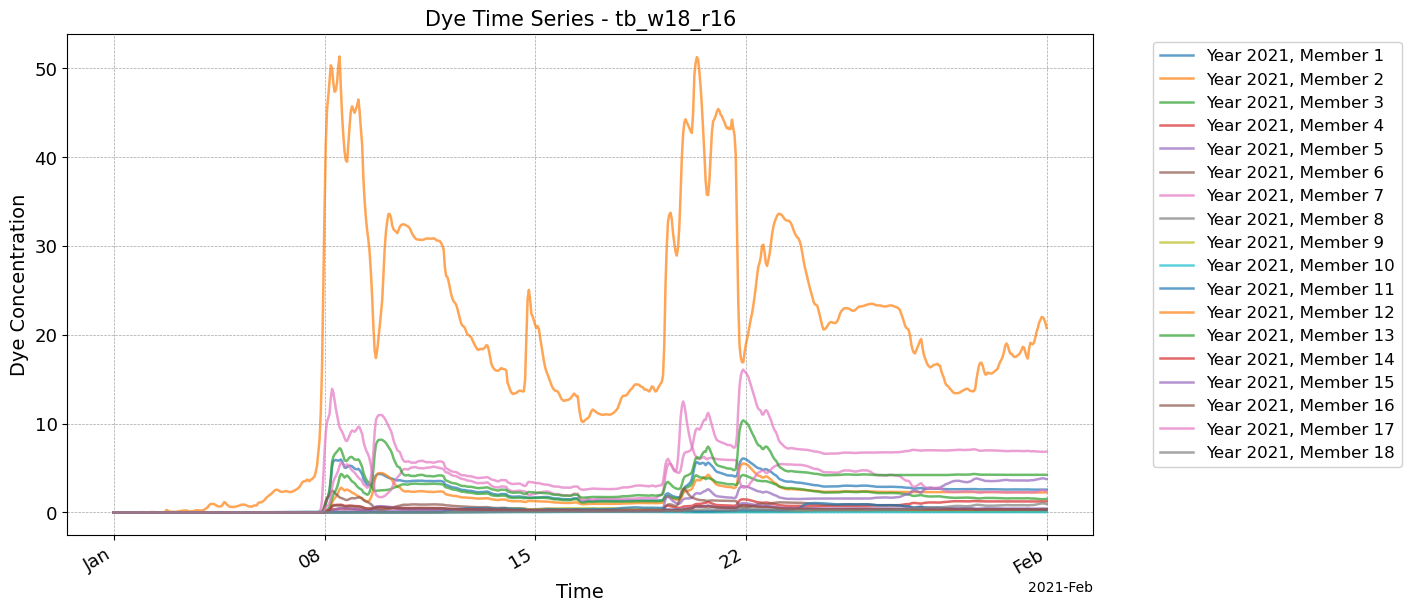

✓ Saved: /home/pj24001722/ku40000343/Github/xfvcom/examples/output/dye_timeseries.png
Time axis: Exactly 7 ticks maximum (guaranteed no overlap)


In [6]:
# Time series plot using xfvcom utilities
print("Creating time series plot with enhanced formatting...")

# Create plot configuration with larger fonts
cfg = FvcomPlotConfig(
    figsize=(14, 6),
    fontsize={
        "xticks": 13,
        "yticks": 13,
        "xlabel": 14,
        "ylabel": 14,
        "title": 15,
        "legend": 12,
    },
    linewidth={"plot": 1.8},
)

# Use the utility function for plotting with automatic time axis formatting
# Default: maximum 7 ticks to ensure no overlap
fig, ax = plot_ensemble_timeseries(
    ds,
    var_name="dye",
    cfg=cfg,
    max_lines=18,
    alpha=0.7,
    legend_outside=True,
    title=f"Dye Time Series - {basename}",
    ylabel="Dye Concentration"
    # Default: max 7 ticks, 30° rotation - guaranteed no overlap
)

plt.savefig(output_dir / "dye_timeseries.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"✓ Saved: {output_dir / 'dye_timeseries.png'}")
print(f"Time axis: Exactly 7 ticks maximum (guaranteed no overlap)")

### 6.1 Manual Time Axis Control (Optional)

The plotting utilities support manual control of time axis formatting:
- **minticks**: Minimum number of ticks (default: 3)
- **maxticks**: Maximum number of ticks (default: 7)
- **rotation**: Label rotation angle in degrees (default: 30)

Example: Manual time axis control

Option A: Fewer ticks for cleaner look


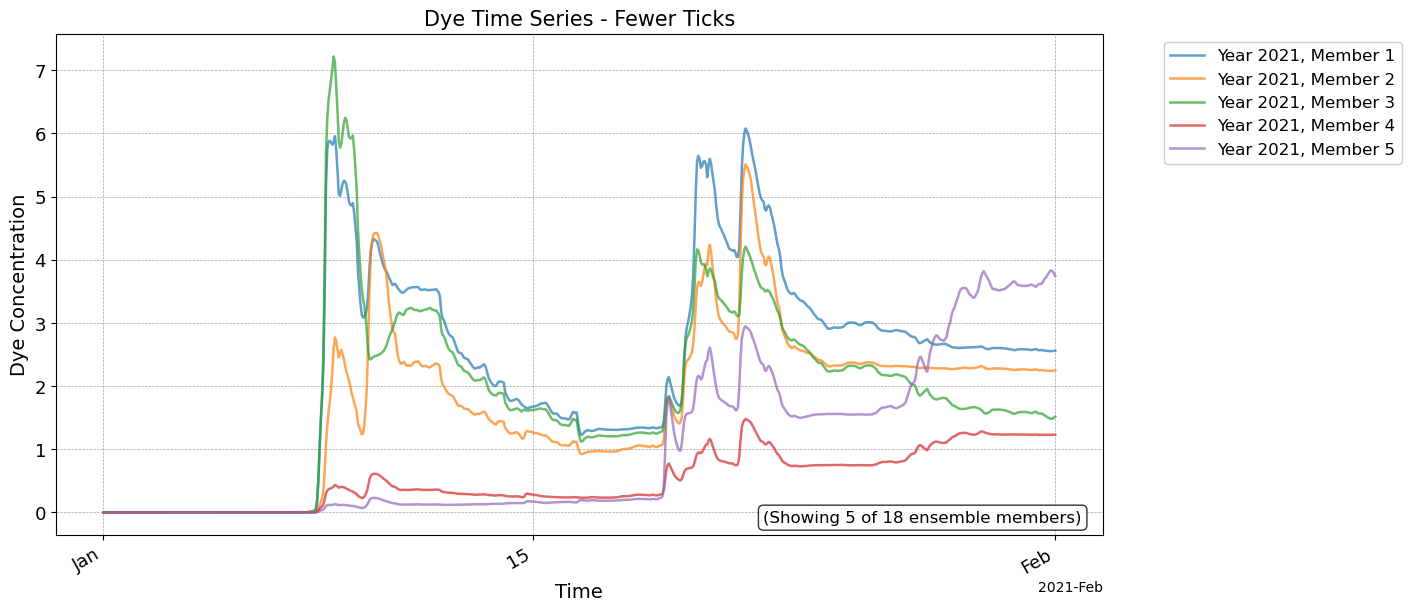

✓ Created plot with 2-5 ticks

Option B: More ticks for detailed timeline


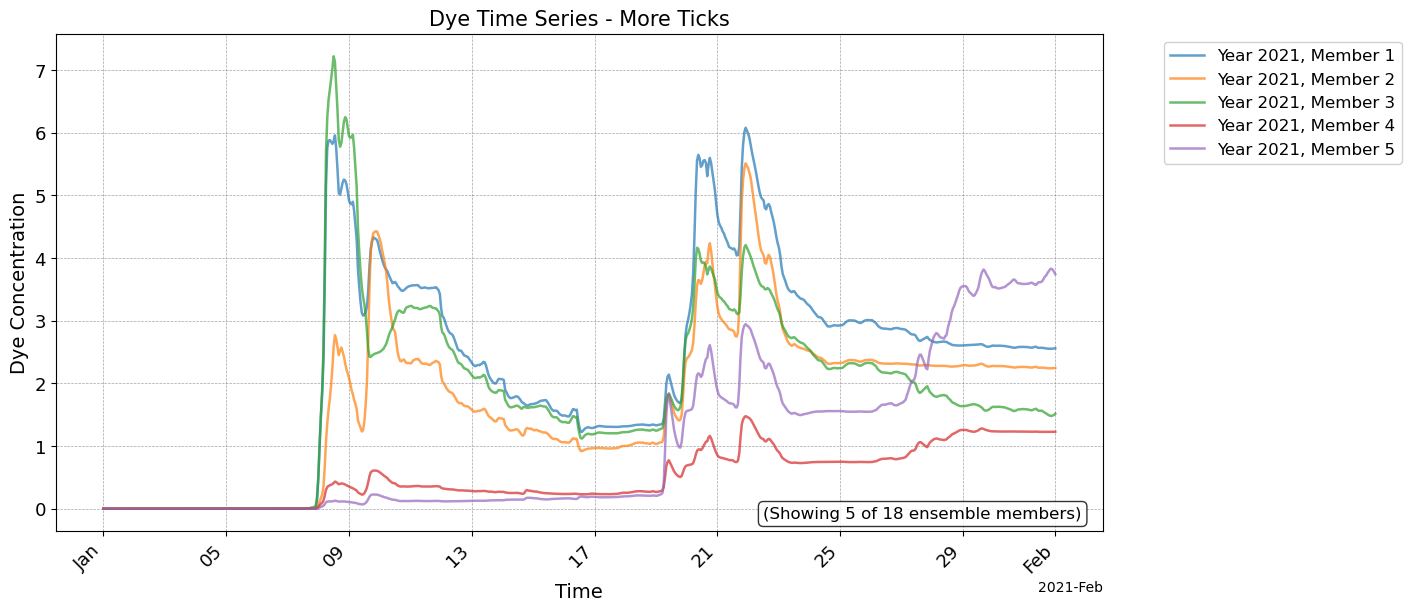

✓ Created plot with 5-10 ticks

Option C: Steeper rotation for space efficiency


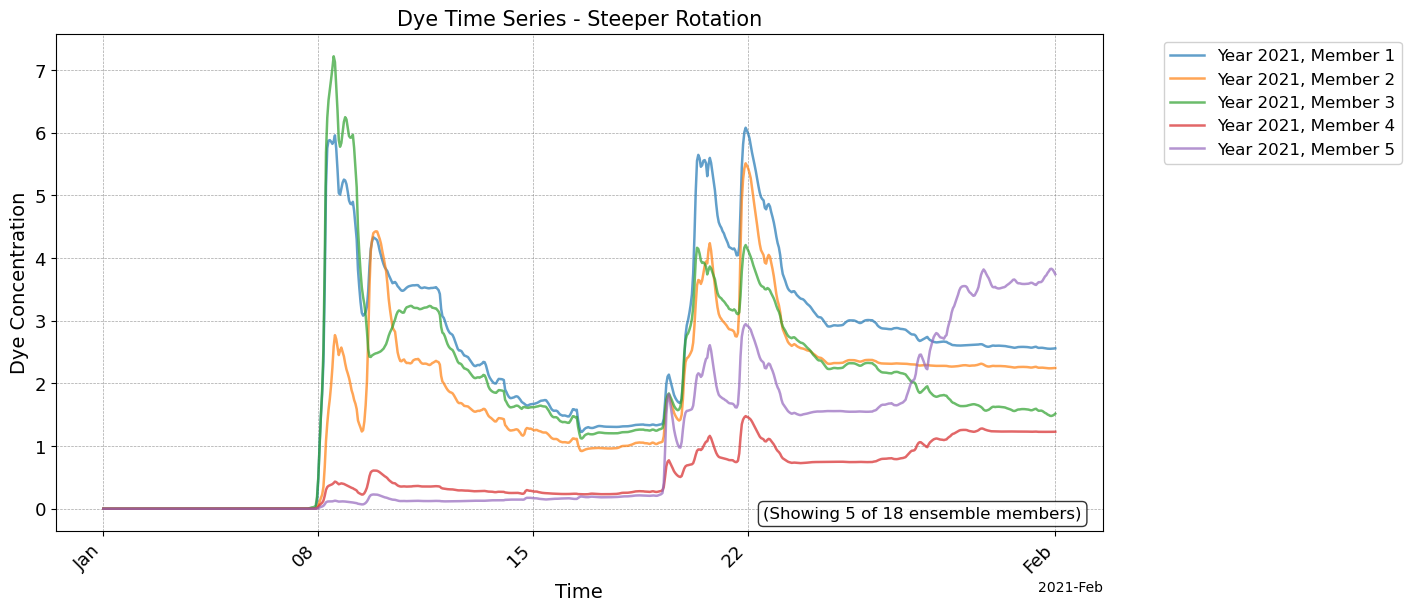

✓ Created plot with 45° rotation

Manual control options (use only if needed):

1. minticks/maxticks - Control number of ticks:
   - minticks=2, maxticks=5    : Fewer ticks, wider spacing
   - minticks=3, maxticks=7    : Default, balanced (recommended)
   - minticks=5, maxticks=10   : More ticks, denser timeline

2. rotation - Label angle in degrees:
   - 0°  : Horizontal labels (may overlap easily)
   - 30° : Gentle angle (default, good readability)
   - 45° : Standard angle (more space-efficient)
   - 90° : Vertical labels (hard to read)

Note: matplotlib's AutoDateLocator intelligently formats dates
based on the time range, so manual control is rarely needed.


In [7]:
# Example: Manual time axis control (if automatic formatting needs adjustment)
print("Example: Manual time axis control\n")

# The default automatic formatting should work well for most cases
# Use these manual options only if you need specific control

# Option A: Fewer ticks (more spacing)
print("Option A: Fewer ticks for cleaner look")
fig, ax = plot_ensemble_timeseries(
    ds,
    var_name="dye",
    cfg=cfg,
    max_lines=5,
    alpha=0.7,
    legend_outside=True,
    title="Dye Time Series - Fewer Ticks",
    ylabel="Dye Concentration",
    minticks=2,
    maxticks=5,  # Fewer ticks for wider spacing
    rotation=30
)
plt.savefig(output_dir / "dye_timeseries_fewer_ticks.png", dpi=150, bbox_inches="tight")
plt.show()
print("✓ Created plot with 2-5 ticks\n")

# Option B: More ticks (denser)
print("Option B: More ticks for detailed timeline")
fig, ax = plot_ensemble_timeseries(
    ds,
    var_name="dye",
    cfg=cfg,
    max_lines=5,
    alpha=0.7,
    legend_outside=True,
    title="Dye Time Series - More Ticks",
    ylabel="Dye Concentration",
    minticks=5,
    maxticks=10,  # More ticks for detailed timeline
    rotation=45  # Steeper rotation may help with denser ticks
)
plt.savefig(output_dir / "dye_timeseries_more_ticks.png", dpi=150, bbox_inches="tight")
plt.show()
print("✓ Created plot with 5-10 ticks\n")

# Option C: Adjust rotation angle
print("Option C: Steeper rotation for space efficiency")
fig, ax = plot_ensemble_timeseries(
    ds,
    var_name="dye",
    cfg=cfg,
    max_lines=5,
    alpha=0.7,
    legend_outside=True,
    title="Dye Time Series - Steeper Rotation",
    ylabel="Dye Concentration",
    rotation=45  # Steeper angle
)
plt.savefig(output_dir / "dye_timeseries_rotation45.png", dpi=150, bbox_inches="tight")
plt.show()
print("✓ Created plot with 45° rotation\n")

# Summary of manual control options:
print("Manual control options (use only if needed):")
print("\n1. minticks/maxticks - Control number of ticks:")
print("   - minticks=2, maxticks=5    : Fewer ticks, wider spacing")
print("   - minticks=3, maxticks=7    : Default, balanced (recommended)")
print("   - minticks=5, maxticks=10   : More ticks, denser timeline")
print("\n2. rotation - Label angle in degrees:")
print("   - 0°  : Horizontal labels (may overlap easily)")
print("   - 30° : Gentle angle (default, good readability)")
print("   - 45° : Standard angle (more space-efficient)")
print("   - 90° : Vertical labels (hard to read)")
print("\nNote: matplotlib's AutoDateLocator intelligently formats dates")
print("based on the time range, so manual control is rarely needed.")

Creating ensemble statistics plot with enhanced formatting...


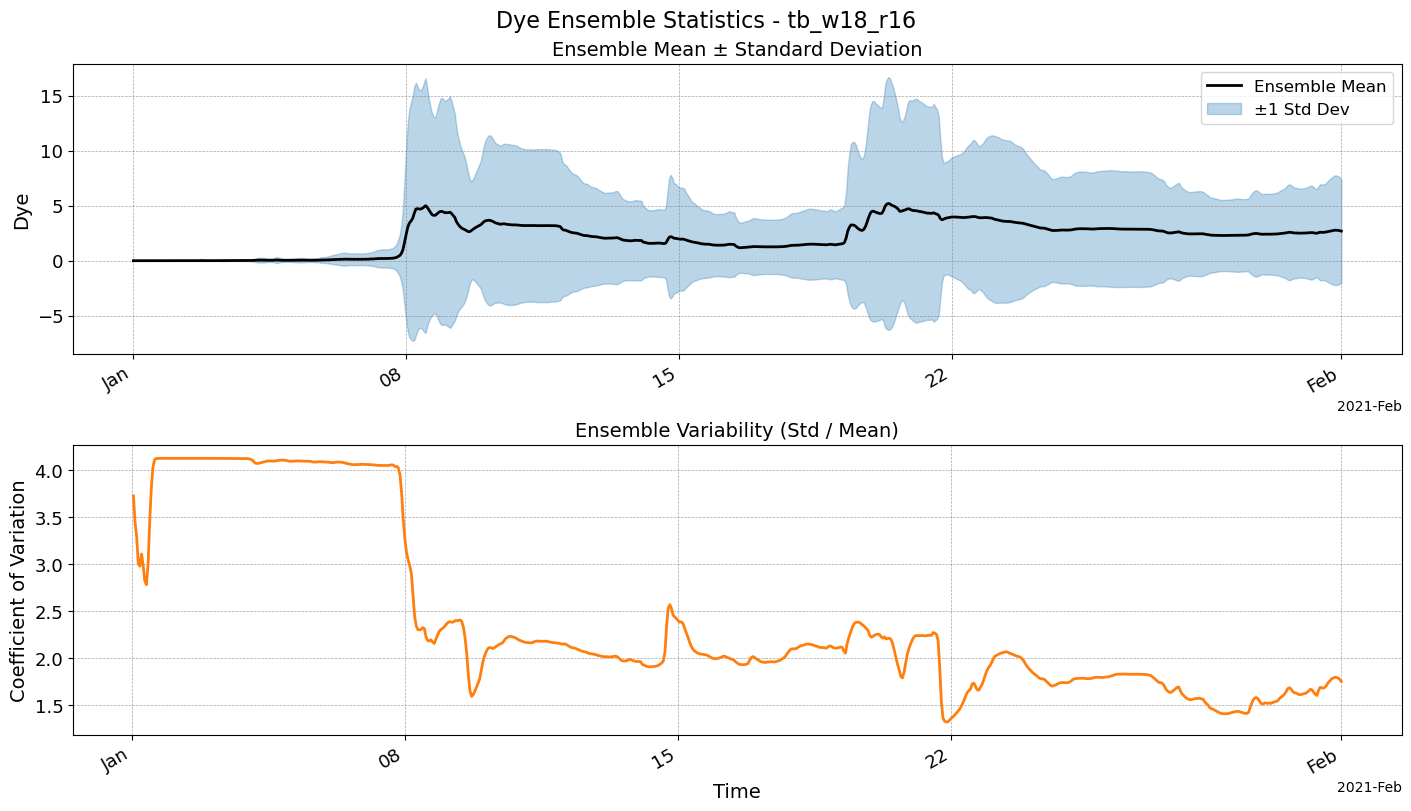

✓ Saved: /home/pj24001722/ku40000343/Github/xfvcom/examples/output/dye_statistics.png
Time axis: Exactly 7 ticks maximum on both subplots


In [8]:
# Statistical summary plot using xfvcom utilities
if "dye" in ds and "ensemble" in ds["dye"].dims:
    print("Creating ensemble statistics plot with enhanced formatting...")
    
    # Create plot configuration with larger fonts
    cfg = FvcomPlotConfig(
        figsize=(14, 8),
        fontsize={
            "xticks": 13,
            "yticks": 13,
            "xlabel": 14,
            "ylabel": 14,
            "title": 14,
            "suptitle": 16,
            "legend": 12,
        },
        linewidth={"plot": 2.0},
    )
    
    # Use the utility function for ensemble statistics
    # Default: exactly 7 ticks maximum on both axes
    fig, (ax1, ax2) = plot_ensemble_statistics(
        ds,
        var_name="dye",
        cfg=cfg,
        title=f"Dye Ensemble Statistics - {basename}"
        # Default: max 7 ticks, 30° rotation - guaranteed no overlap
    )
    
    plt.savefig(output_dir / "dye_statistics.png", dpi=150, bbox_inches="tight")
    plt.show()
    
    print(f"✓ Saved: {output_dir / 'dye_statistics.png'}")
    print(f"Time axis: Exactly 7 ticks maximum on both subplots")
else:
    print("Skipping ensemble statistics (no ensemble dimension)")

In [9]:
# Calendar heatmap (if using same_calendar or climatology mode)
if align_mode in ["same_calendar", "climatology"]:
    print("Creating calendar visualization with enhanced formatting...")
    print("Note: Calendar heatmap visualization for same_calendar/climatology modes")
    print("This shows dye concentration by (month, day, hour)")
    
    # Create plot configuration
    cfg = FvcomPlotConfig(
        figsize=(12, 5),
        fontsize={
            "xticks": 13,
            "yticks": 13,
            "xlabel": 14,
            "ylabel": 14,
            "title": 15,
        },
        linewidth={"plot": 2.0},
    )
    
    # Example: Simple monthly mean if data allows
    if "time" in ds.coords:
        time_pd = pd.DatetimeIndex(ds.time.values)
        ds_temp = ds.assign_coords(month=time_pd.month)
        
        if "dye" in ds_temp:
            monthly_mean = ds_temp["dye"].groupby("month").mean()
            
            fig, ax = plt.subplots(figsize=cfg.figsize)
            if "ensemble" in monthly_mean.dims:
                monthly_mean.mean(dim="ensemble").plot(
                    ax=ax, 
                    marker="o", 
                    linewidth=cfg.linewidth_plot,
                    markersize=8,
                    color=cfg.color_cycle[0]
                )
            else:
                monthly_mean.plot(
                    ax=ax, 
                    marker="o", 
                    linewidth=cfg.linewidth_plot,
                    markersize=8
                )
            
            ax.set_xlabel("Month", fontsize=cfg.fontsize_xlabel)
            ax.set_ylabel("Mean Dye Concentration", fontsize=cfg.fontsize_ylabel)
            ax.set_title("Monthly Mean Dye Concentration", fontsize=cfg.fontsize_title)
            ax.grid(
                True, 
                alpha=cfg.grid_alpha, 
                linestyle=cfg.grid_linestyle,
                linewidth=cfg.grid_linewidth,
                color=cfg.grid_color
            )
            ax.tick_params(
                axis="both", 
                labelsize=cfg.fontsize_xticks,
                width=cfg.linewidth_tick_params
            )
            
            plt.tight_layout()
            plt.savefig(output_dir / "dye_monthly.png", dpi=150, bbox_inches="tight")
            plt.show()
            
            print(f"✓ Saved: {output_dir / 'dye_monthly.png'}")
else:
    print("Skipping calendar visualization (not using same_calendar or climatology mode)")

Skipping calendar visualization (not using same_calendar or climatology mode)


## 7. Save Results

Export the dataset to NetCDF and Zarr formats.

In [10]:
# Helper function to prepare dataset for Zarr
def prepare_for_zarr(ds, time_chunk_size=100):
    """Prepare dataset for Zarr export with proper chunking and encoding.
    
    Parameters
    ----------
    ds : xr.Dataset
        Dataset to prepare
    time_chunk_size : int
        Chunk size for time dimension
    
    Returns
    -------
    tuple[xr.Dataset, dict]
        Chunked dataset and encoding dictionary
    """
    # Create chunk dictionary
    chunk_dict = {}
    for dim in ds.dims:
        if dim == "time":
            chunk_dict[dim] = min(time_chunk_size, len(ds[dim]))
        else:
            # Keep other dimensions unchunked for efficient access
            chunk_dict[dim] = len(ds[dim])
    
    # Chunk the dataset
    ds_chunked = ds.chunk(chunk_dict)
    
    # Create encoding with explicit chunks for all variables
    encoding = {}
    for var in ds_chunked.data_vars:
        var_chunks = []
        for dim in ds_chunked[var].dims:
            var_chunks.append(chunk_dict.get(dim, 1))
        encoding[var] = {"chunks": tuple(var_chunks)}
    
    # Add encoding for coordinates with dimensions (excluding scalar coords)
    for coord in ds_chunked.coords:
        if ds_chunked[coord].dims:  # Only if coordinate has dimensions
            coord_chunks = []
            for dim in ds_chunked[coord].dims:
                coord_chunks.append(chunk_dict.get(dim, 1))
            encoding[coord] = {"chunks": tuple(coord_chunks)}
    
    return ds_chunked, encoding


# Save as NetCDF
nc_path = output_dir / f"dye_series_{basename}_{align_mode}.nc"
print(f"Saving NetCDF to {nc_path}...")

# NetCDF doesn't support MultiIndex - convert to regular coordinates
ds_to_save = ds.reset_index("ensemble") if "ensemble" in ds.indexes and isinstance(ds.indexes["ensemble"], pd.MultiIndex) else ds

ds_to_save.to_netcdf(nc_path)
print(f"✓ Saved: {nc_path} ({nc_path.stat().st_size / 1e6:.2f} MB)")
if ds_to_save is not ds:
    print(f"  Note: MultiIndex 'ensemble' was converted to separate 'year' and 'member' coordinates")

# Save as Zarr
zarr_path = output_dir / f"dye_series_{basename}_{align_mode}.zarr"
print(f"\nSaving Zarr to {zarr_path}...")

# For demo, save a subset if dataset is large
if "time" in ds.dims and len(ds.time) > 100:
    ds_subset = ds.isel(time=slice(0, 100))
    print(f"  (Saving subset: first 100 time steps for demo)")
    # Reset MultiIndex for consistency
    ds_subset_to_save = ds_subset.reset_index("ensemble") if "ensemble" in ds_subset.indexes and isinstance(ds_subset.indexes["ensemble"], pd.MultiIndex) else ds_subset
    
    # Prepare with proper encoding
    ds_subset_chunked, encoding = prepare_for_zarr(ds_subset_to_save, time_chunk_size=100)
    ds_subset_chunked.to_zarr(zarr_path, mode="w", encoding=encoding, 
                               zarr_version=2, consolidated=False)
else:
    # Prepare full dataset with proper encoding
    ds_to_save_chunked, encoding = prepare_for_zarr(ds_to_save, time_chunk_size=100)
    ds_to_save_chunked.to_zarr(zarr_path, mode="w", encoding=encoding, 
                                zarr_version=2, consolidated=False)

print(f"✓ Saved: {zarr_path}")

# Summary
print("\n" + "="*60)
print("SAVE COMPLETE")
print("="*60)
print(f"Output directory: {output_dir}")
print(f"Files created:")
for f in sorted(output_dir.glob("*")):
    if f.is_file():
        size = f.stat().st_size / 1e6
        print(f"  - {f.name} ({size:.2f} MB)")
    elif f.is_dir():
        print(f"  - {f.name}/ (directory)")

Saving NetCDF to /home/pj24001722/ku40000343/Github/xfvcom/examples/output/dye_series_tb_w18_r16_native_intersection.nc...
✓ Saved: /home/pj24001722/ku40000343/Github/xfvcom/examples/output/dye_series_tb_w18_r16_native_intersection.nc (0.13 MB)
  Note: MultiIndex 'ensemble' was converted to separate 'year' and 'member' coordinates

Saving Zarr to /home/pj24001722/ku40000343/Github/xfvcom/examples/output/dye_series_tb_w18_r16_native_intersection.zarr...
  (Saving subset: first 100 time steps for demo)
✓ Saved: /home/pj24001722/ku40000343/Github/xfvcom/examples/output/dye_series_tb_w18_r16_native_intersection.zarr

SAVE COMPLETE
Output directory: /home/pj24001722/ku40000343/Github/xfvcom/examples/output
Files created:
  - dye_series_tb_w18_r16_native_intersection.nc (0.13 MB)
  - dye_series_tb_w18_r16_native_intersection.zarr/ (directory)
  - dye_statistics.png (0.23 MB)
  - dye_timeseries.png (0.27 MB)
  - dye_timeseries_fewer_ticks.png (0.22 MB)
  - dye_timeseries_more_ticks.png (0.24 

## 8. Summary

Review the extraction and analysis results.

In [11]:
print("EXTRACTION SUMMARY")
print("="*60)
print(f"Configuration:")
print(f"  Basename:        {basename}")
print(f"  Years:           {years}")
print(f"  Members:         {members}")
print(f"  Nodes selected:  {nodes}")
print(f"  Sigma layers:    {sigmas}")
print(f"  Negative policy: {neg_policy}")
print(f"  Alignment mode:  {align_mode}")
print()
print(f"Results:")
print(f"  Time steps:      {ds.sizes.get('time', 'N/A')}")
print(f"  Ensemble size:   {ds.sizes.get('ensemble', 'N/A')}")
print(f"  Data variables:  {list(ds.data_vars)}")
print()
print(f"Outputs:")
print(f"  NetCDF:          {nc_path.name}")
print(f"  Zarr:            {zarr_path.name}")
print(f"  Figures:         {len(list(output_dir.glob('*.png')))} PNG files")
print("="*60)

# Display dataset attributes
print("\nDataset Attributes:")
for key, val in ds.attrs.items():
    if isinstance(val, str) and len(val) > 100:
        print(f"  {key}: <long string>")
    else:
        print(f"  {key}: {val}")

EXTRACTION SUMMARY
Configuration:
  Basename:        tb_w18_r16
  Years:           [2021]
  Members:         [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
  Nodes selected:  [100]
  Sigma layers:    [0]
  Negative policy: keep
  Alignment mode:  native_intersection

Results:
  Time steps:      745
  Ensemble size:   18
  Data variables:  ['dye']

Outputs:
  NetCDF:          dye_series_tb_w18_r16_native_intersection.nc
  Zarr:            dye_series_tb_w18_r16_native_intersection.zarr
  Figures:         5 PNG files

Dataset Attributes:
  basename: tb_w18_r16
  nodes_selected: [100]
  sigmas_selected: [0]
  negative_policy: keep
  alignment_mode: native_intersection
  n_years: 1
  n_members: 18
  tool: xfvcom.dye_timeseries
  time_steps: 745
  negative_stats: <long string>
